# Online store comments policy

Users of an online store can edit and supplement product descriptions. The store needs to filter toxic comments in order to submit them for moderation. The project is to train the model which will classify comments into positive and negative. At our disposal is a dataset with markup on the toxicity of edits.

Metrics is *F1* and it should not be less than  0.75. 

## Contents

<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span><ul class="toc-item"><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Machine-learning" data-toc-modified-id="Machine-learning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Machine learning</a></span><ul class="toc-item"><li><span><a href="#Conclusions_2" data-toc-modified-id="Conclusions_2-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conclusions_2</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

## Data preprocessing

In [19]:
#imports

import pandas as pd

import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.svm import LinearSVC

from sklearn.metrics import f1_score

In [21]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [22]:
df.groupby('toxic').count()

,text
toxic,
0,143346
1,16225


The data is text marked up for toxic and non-toxic comments. Markup (`toxic`) is a **target** where class imbalance occurs: class 0 is present in ~90% of cases. It is proposed to take this factor into account at the model building stage, through the `class_weight = 'balanced'` argument.
To create features from text, the following steps will be performed:

1) Word lemmas will be found; <br/>
2) The features will be encoded by specifying the word weight via Tfidf.

In [23]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text_tokenized = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in text_tokenized])
df['text_lemma'] = df['text'].apply(lemmatize_text)

In [5]:
df.head()

,text,toxic,text_lemma
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D'aww ! He match this background colour I 'm s...
2,"Hey man, I'm really not trying to edit war. It...",0,"Hey man , I 'm really not trying to edit war ...."
3,"""\nMore\nI can't make any real suggestions on ...",0,`` More I ca n't make any real suggestion on i...
4,"You, sir, are my hero. Any chance you remember...",0,"You , sir , are my hero . Any chance you remem..."


In [24]:
x = df['text_lemma']
y = df['toxic']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=12345)

In [25]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords, min_df = 0.00001)
tf_idf = count_tf_idf.fit(x_train)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
tf_idf

TfidfVectorizer(min_df=1e-05,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [9]:
x_train = tf_idf.transform(x_train)
x_train.shape #sample size check

(119678, 60670)

In [10]:
x_valid = tf_idf.transform(x_valid)
x_valid.shape #sample size check

(39893, 60670)

### Conclusions
At the first step, the data was uploaded, preprocessed and prepared for loading into the model: lemmatization and vectorization using Tfidf with stop words was done.

## Machine learning

In [11]:
%%time
model = LogisticRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_valid)
f1_score(y_valid, predictions)

CPU times: user 16.5 s, sys: 21.8 s, total: 38.3 s
Wall time: 38.3 s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7374153664998528

In [12]:
%%time
model = LogisticRegression(class_weight = 'balanced')
model.fit(x_train, y_train)
predictions = model.predict(x_valid)
f1_score(y_valid, predictions)

CPU times: user 15.6 s, sys: 20.1 s, total: 35.6 s
Wall time: 35.6 s


0.7508305647840532

In [19]:
%%time
model = SGDClassifier(class_weight = 'balanced', random_state = 12345)
model.fit(x_train, y_train)
predictions = model.predict(x_valid)
f1_score(y_valid, predictions)

CPU times: user 468 ms, sys: 117 ms, total: 585 ms
Wall time: 586 ms


0.7363173525668223

In [18]:
%%time
model = DecisionTreeClassifier(random_state = 12345, max_depth = 200)
model.fit(x_train, y_train)
predictions = model.predict(x_valid)
f1_score(y_valid, predictions)

CPU times: user 1min 28s, sys: 147 ms, total: 1min 28s
Wall time: 1min 28s


0.7187743443261491

In [15]:
%%time
model = CatBoostClassifier(iterations=100, verbose=10, learning_rate=0.7, auto_class_weights = 'Balanced')
model.fit(x_train, y_train)
predictions = model.predict(x_valid)
f1_score(y_valid, predictions)

0:	learn: 0.5494211	total: 3.63s	remaining: 5m 59s
10:	learn: 0.3775858	total: 24.3s	remaining: 3m 16s
20:	learn: 0.3271049	total: 44.7s	remaining: 2m 48s
30:	learn: 0.2942124	total: 1m 4s	remaining: 2m 23s
40:	learn: 0.2743270	total: 1m 24s	remaining: 2m 1s
50:	learn: 0.2572384	total: 1m 43s	remaining: 1m 39s
60:	learn: 0.2451524	total: 2m 2s	remaining: 1m 18s
70:	learn: 0.2344070	total: 2m 22s	remaining: 58.1s
80:	learn: 0.2259313	total: 2m 41s	remaining: 38s
90:	learn: 0.2168320	total: 3m 2s	remaining: 18s
99:	learn: 0.2111894	total: 3m 20s	remaining: 0us
CPU times: user 3min 34s, sys: 2.45 s, total: 3min 36s
Wall time: 3min 37s


0.7216428341038599

In [16]:
%%time
model = lgb.LGBMClassifier(class_weight = 'balanced', random_state = 12345)
model.fit(x_train, y_train)
predictions = model.predict(x_valid)
f1_score(y_valid, predictions)

CPU times: user 9min 9s, sys: 2.54 s, total: 9min 12s
Wall time: 9min 15s


0.7257886609309507

In [17]:
%%time
model = LinearSVC(class_weight = 'balanced', random_state = 12345)
model.fit(x_train, y_train)
predictions = model.predict(x_valid)
f1_score(y_valid, predictions)

CPU times: user 3.2 s, sys: 42 ms, total: 3.24 s
Wall time: 3.26 s


0.7499442337720277

### Conclusions_2
The best F1 score on the test data was shown by the Logistic Regression model with class balancing.

## Summary

| Model | F1 | Learning and prediction time, minutes  
| --- | --- | --- |
| Logistic Regression () | 0.737 | 0.6 | 
| Logistic Regression (class-weight) | **0.751** | 0.6 | 
| SGDClassifier | 0.736 | <0.1 | 
| Decision Tree | 0.719 | 1.5 | 
| CatBoostClassifier | 0.722 | 3.6 | 
| LGBMClassifier | 0.726 | 9.2 | 
| LinearSVC | 0.75 | <0.1 |

The highest value of the F1 metric was shown by the **Logistic Regression (class_weight = balanced)** model. Besides, the value of the metric exceeds 0.75. Additionally, the running time of the model (training and prediction) was calculated. The model showed one of the highest speeds - less than 1 minute (35 seconds) total time.

Initially, there is a class imbalance in the data: positive comments make up approximately 90% of the population. This complicated the search for negative comments for the model and affected the final distribution of classes on the test data. 

Please see below.

In [22]:
model = LogisticRegression(class_weight = 'balanced')
model.fit(x_train, y_train)
predictions = model.predict(x_valid)
predictions

array([1, 0, 0, ..., 0, 0, 0])

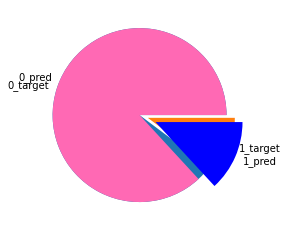

In [94]:
import matplotlib.pyplot as plt

mycolors = ["hotpink", "b",]
label_target = ['0_target', '1_target']
label_pred = ['0_pred', '1_pred']        
myexplode = [0, 0.1]
myexplode_1 = [0, 0.2]

plt.pie(y_valid.value_counts(), labels = label_target, explode = myexplode)
plt.pie(pd.Series(predictions).value_counts(), colors = mycolors, labels = label_pred, explode = myexplode_1)

plt.show()